In [1]:
import os
import math
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Music Genre Classification

## Background and data

I've seen many people online use the [GTZAN dataset](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification) to create a music genre classification model.

The GTZAN dataset contains the following files:

* 1000 song clips from 10 different genres, all having a length of 30 seconds

* Spectrograms of each clip - a visual representation of the audio

* 2 CSV files containing various metadata for each song clip. One file containing data for the original 1000 clips, and the other containing data for the clips broken down into 3-second chunks

Many of the models I've seen were able to get an accuracy of over 90%, but I noticed that they had a common issue. When splitting the data into a training/test set, most people took the CSV of 3-second clips, did a random split and then built a tabular classification model.

The problem with this is that each song is represented by 10 different clips in that CSV file. This means that when the model attempts to predict the genre of one of the clips in the test set, the chances are that the model has already been trained on several other clips from the same song. This is an example of data leakage, and it will artificially inflate the test accuracy.

With that in mind, I wanted to build my own model to see what kind of accuracy is realistically achievable. 

## Data Preparation and Exploration

In [2]:
os.chdir('C:/Users/tb450/Desktop/Work etc/Music Data/Data')

In [3]:
df_music = pd.read_csv("features_3_sec.csv") 
df_music = df_music[df_music['filename'].str[:10] != "jazz.00054"] # this file is corrupt
df_music.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [4]:
df_music.shape

(9980, 60)

In [5]:
df_music.isna().sum().sum()

0

In [6]:
x_cols = list(set(df_music.columns) - set(['filename', 'length', 'label']))
y_col = 'label'

Convert the labels into integers

In [7]:
label_encoder = LabelEncoder()
df_music[y_col] = label_encoder.fit_transform(df_music[y_col])
df_music[y_col].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### Distributions

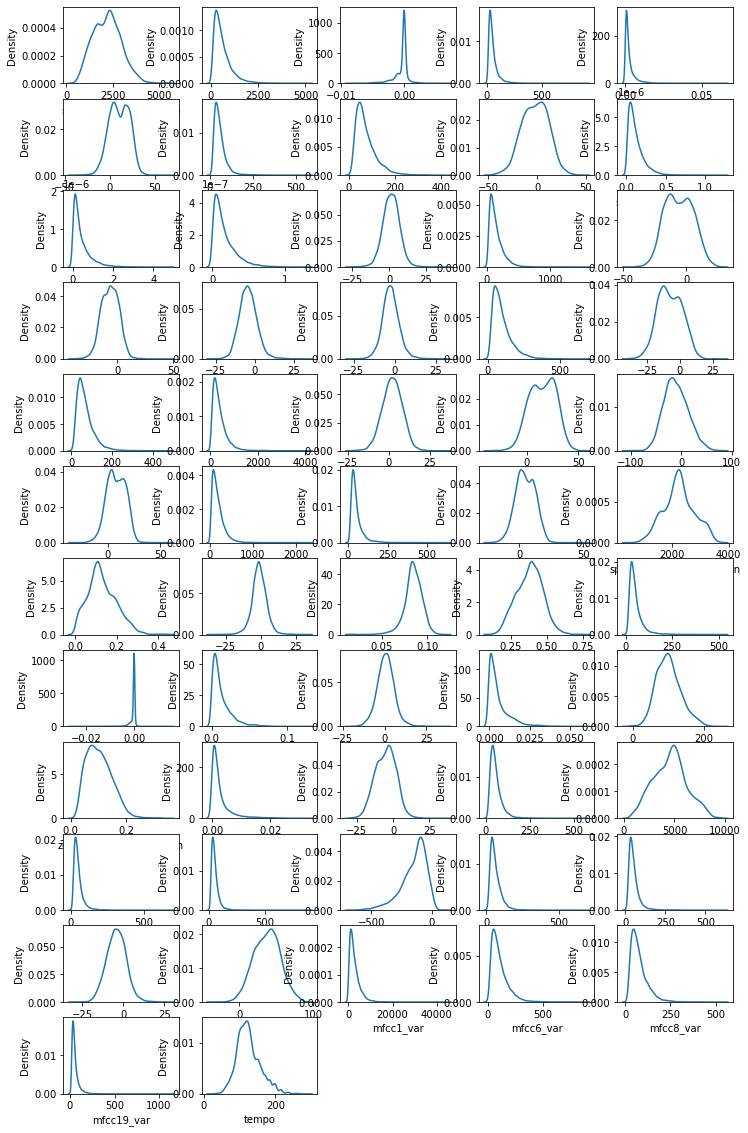

In [8]:
rows = int(np.ceil(len(x_cols)/5))
    
fig = plt.figure(figsize = (12,20))
for i in range(len(x_cols)):
    fig.add_subplot(rows, 5, i+1)
    sns.kdeplot(df_music[x_cols[i]])
plt.show()


Most of the variables are either roughly bell-shaped, or right-skewed. All the variables will be scaled to have roughly the same range of values.

### Correlations

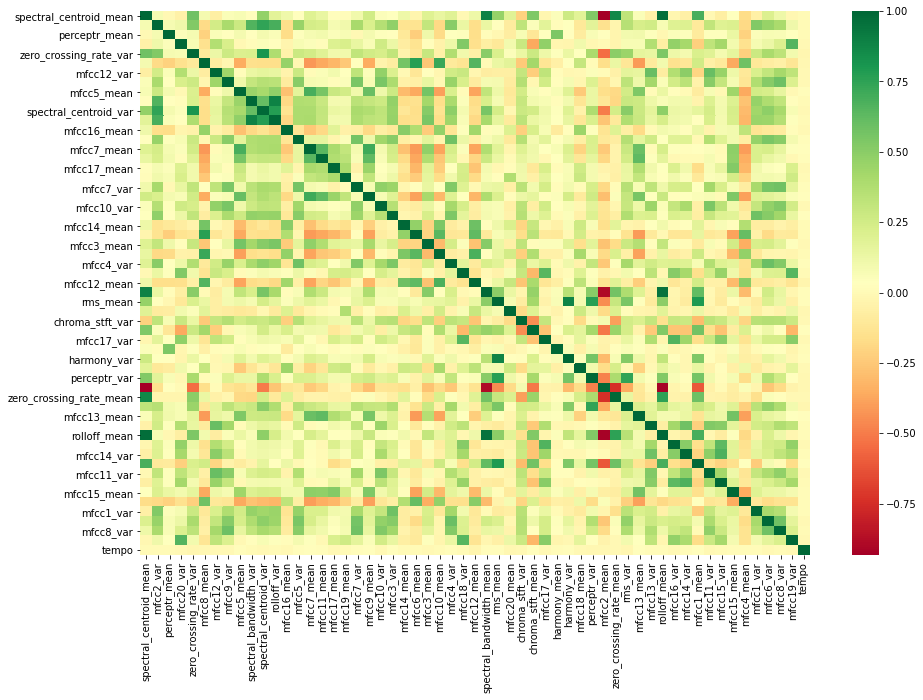

In [9]:
plt.figure(figsize=(15,10))
ax = sns.heatmap(df_music[x_cols].corr(), cmap="RdYlGn", annot=False)

A few of the variables are very strongly correlated with other variables, so I'll remove some of these.

In [10]:
corrs = df_music[x_cols].corr().unstack().sort_values(kind="quicksort")
ix = (abs(corrs) < 1) & (abs(corrs) >= 0.9)
corrs[ix]

mfcc2_mean               spectral_centroid_mean    -0.931408
spectral_centroid_mean   mfcc2_mean                -0.931408
mfcc2_mean               rolloff_mean              -0.923615
rolloff_mean             mfcc2_mean                -0.923615
                         spectral_bandwidth_mean    0.951076
spectral_bandwidth_mean  rolloff_mean               0.951076
rolloff_mean             spectral_centroid_mean     0.974352
spectral_centroid_mean   rolloff_mean               0.974352
dtype: float64

In [11]:
x_cols.remove("spectral_centroid_mean")
x_cols.remove("rolloff_mean")
x_cols.remove("spectral_bandwidth_mean")

### Training/test splits

Each song has 10 clips, so we have to ensure that clips from the same song don't appear in both the training and validation/test sets, as explained in the Background section.

To do this, I'll randomly split based on the songname, and then assign the 3-second clips accordingly. 

In [12]:
df_music['song'] = df_music['filename'].str.replace(".\d.wav", "", regex=True)
df_music['clip'] = df_music['filename'].str.extract(r'.(\d).wav')

In [13]:
songs = df_music['song'].unique()
random.seed(30)
random.shuffle(songs)
splits = ["train"] * 700 + ["valid"] * 200 + ["test"] * 100
split_dict = dict(zip(songs, splits))
df_music['split'] = list(map(lambda x: split_dict[x], df_music['song']))

In [14]:
df_train = df_music[df_music['split']=="train"]
df_valid = df_music[df_music['split']=="valid"]
df_test = df_music[df_music['split']=="test"]

In [15]:
X_train_df = df_train[x_cols]
X_valid_df = df_valid[x_cols]
X_test_df = df_test[x_cols]
y_train_df = df_train[y_col]
y_valid_df = df_valid[y_col]
y_test_df = df_test[y_col]

print(X_valid_df.shape, y_valid_df.shape)
print(X_test_df.shape, y_test_df.shape)

(2000, 54) (2000,)
(990, 54) (990,)


Scaling the variables to have a range of roughly [0, 1]

In [16]:
scaler = StandardScaler()
X_train_df = scaler.fit_transform(X_train_df)
X_valid_df = scaler.transform(X_valid_df)
X_test_df = scaler.transform(X_test_df)

### PCA

Visualizing the data by genre, based on the first two principal components. 

Principal Component Analysis is used to find ways of representing a dataset in fewer dimensions, while sacrificing as little information as possible.  

In [17]:
pca = PCA(n_components=2)
components = pca.fit_transform(X_train_df)
pca_df = pd.DataFrame(data = components, columns = ['PC1', 'PC2'])
pca_df = pd.concat([pca_df, y_train_df.reset_index(drop=True)], axis = 1)
pca_df.columns

Index(['PC1', 'PC2', 'label'], dtype='object')

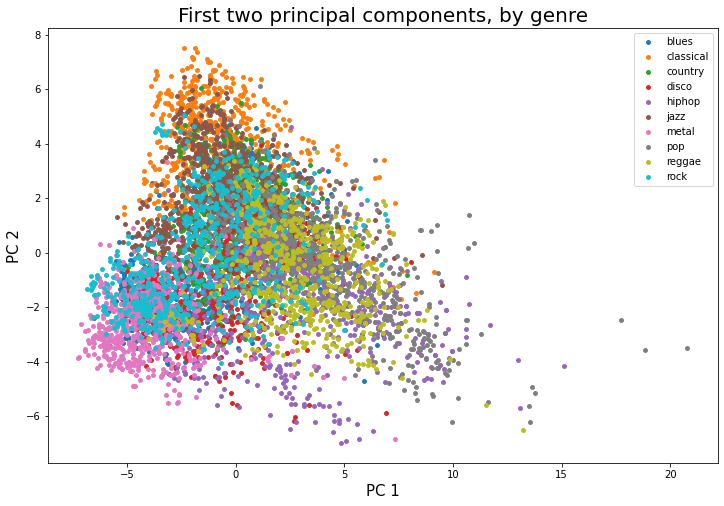

In [18]:
fig, ax = plt.subplots(figsize = (12,8))
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('First two principal components, by genre', fontsize = 20)
for i, genre in enumerate(label_encoder.classes_):
    ix = pca_df[y_col]==i
    x = pca_df.loc[ix,'PC1']
    y = pca_df.loc[ix,'PC2']
    ax.scatter(x, y, s=15, label=genre, cmap='tab10')
ax.legend(label_encoder.classes_)
plt.show()

Even two dimensions is enough to show some clustering of genres, although there's still plenty of overlap. Thankfully metal and classical seem to be comlpletely separate, which gives me some hope for a classification model.

## Models

I don't expect a logistic regression to be the most accurate, but it will give a good baseline for what I can expect with a more complex model.

### (Multinomial) Logistic regression

In [27]:
lr = LogisticRegression(random_state=12, multi_class='multinomial', max_iter=1000)
lr.fit(X_train_df, y_train_df)
lr.score(X_test_df, y_test_df)

0.6434343434343435

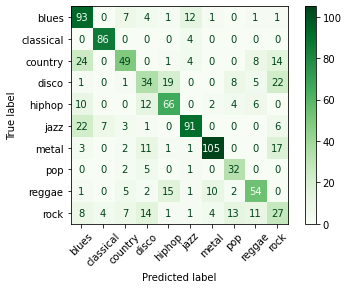

In [29]:
plot_confusion_matrix(lr, X_test_df, y_test_df, display_labels=label_encoder.classes_, xticks_rotation=45, cmap="Greens")

The logistic regression model correctly classified the clips in the test set close to 2/3 of the time. Classical seems to be the easiest to recognize. Rock is often confused with other genres.

### XGBoost

Gradient boosted tree models tend to have a higher performance than logistic regression, but they have a lot of hyperparameters which require tuning. I'll use a randomized search with cross-validation to get a decent hyperparameter set, without it taking too much time.

In [22]:
parameters = {
    "learning_rate": [0.005, 0.01, 0.02, 0.05, 0.075],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [5, 7, 10],
    "max_depth":[8, 10, 12],
    "max_features":["sqrt"],
    "subsample":[0.4, 0.6, 0.8],
    "n_estimators":[750, 1000, 1500],
    "n_iter_no_change": [10]
    }

gbm = RandomizedSearchCV(GradientBoostingClassifier(), parameters, cv=3, n_iter=20, n_jobs=-1, verbose=2)

gbm.fit(X_train_df, y_train_df)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.005, 0.01, 0.02,
                                                          0.05, 0.075],
                                        'max_depth': [8, 10, 12],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [5, 7, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [750, 1000, 1500],
                                        'n_iter_no_change': [10],
                                        'subsample': [0.4, 0.6, 0.8]},
                   verbose=2)

In [23]:
gbm.score(X_test_df, y_test_df)

0.7515151515151515

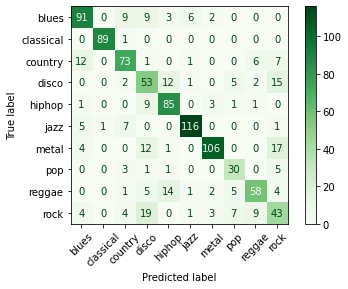

In [33]:
y_pred = gbm.predict(X_test_df)
cm = confusion_matrix(y_test_df, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_).plot(xticks_rotation=45, cmap="Greens")

The XGboost model correctly identifies the genre around 3/4 of the time. Rock is still often confused with other genres.

### Neural network

Let's see how a fully connected neural network compares to the XGboost model.

In [42]:
def plot_history(hist):
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Since the dataset is relatively small, I'll utilize dropout layers to help reduce overfitting.

In [73]:
nn = keras.Sequential()
nn.add(layers.Dense(500, activation='relu', input_shape=(X_train_df.shape[1],)))
nn.add(layers.Dropout(0.5))
nn.add(layers.Dense(200, activation='relu'))
nn.add(layers.Dropout(0.3))
nn.add(layers.Dense(100, activation='relu'))
nn.add(layers.Dropout(0.2))
nn.add(layers.Dense(20, activation='relu'))
nn.add(layers.Dropout(0.1))
nn.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))
nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 500)               27500     
                                                                 
 dropout_19 (Dropout)        (None, 500)               0         
                                                                 
 dense_21 (Dense)            (None, 200)               100200    
                                                                 
 dropout_20 (Dropout)        (None, 200)               0         
                                                                 
 dense_22 (Dense)            (None, 100)               20100     
                                                                 
 dropout_21 (Dropout)        (None, 100)               0         
                                                                 
 dense_23 (Dense)            (None, 20)               

In [74]:
nn.compile(loss="sparse_categorical_crossentropy",
           optimizer='adam', 
           metrics=['acc'])

In [75]:
history = nn.fit(X_train_df, y_train_df, epochs=30, validation_data=(X_valid_df, y_valid_df), verbose=0)

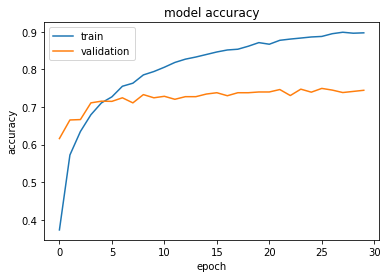

In [76]:
plot_history(history)

In [77]:
y_pred = np.argmax(nn.predict(X_test_df), axis=1)

31/31 [==============================] - 0s 1ms/step


In [78]:
sum(y_pred == y_test_df)/len(y_pred)

0.7383838383838384

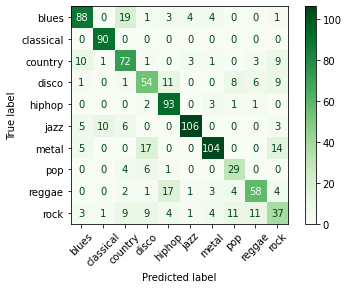

In [79]:
cm = confusion_matrix(y_test_df, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_).plot(xticks_rotation=45, cmap="Greens")

The neural network achieved similar accuracy to XGBoost. I have no doubt that both could be further refined, but for now let's move on.

### Neural network - tabular with image

The dataset also includes spectrograms of each song. I'd like to see if a neural network could glean some additional information from these. These will need to be split into 10 slices, since they represent the whole 30-second clips instead of the 3-second clips.

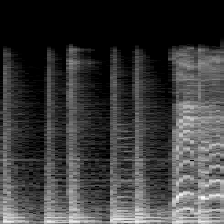

In [41]:
image = Image.open('images_3_secs/blues/blues.00001_0.png')
display(image)

In [30]:
batch_size = 8
image_size = (224, 224, 1) 

I'll create a class that can generate an image and a matrix of metadata for each clip in the CSV file.

In [31]:
class MixedDataGen(keras.utils.Sequence):
    def __init__(self, df, X, y, batch_size, img_size, shuffle=True):
        self.df = df.copy().reindex()
        self.X = X
        self.y = np.array(y)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __len__(self):
        return math.ceil(len(self.y) / self.batch_size)
    
    def on_epoch_end(self):
        # At the end of each epoch, shuffle the indices if shuffle = True 
        self.indices = np.arange(len(self.y))
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __load_image(self, img_name):
        img = Image.open(f"{img_name}").convert('L')
        img = img.resize((self.img_size[0], self.img_size[1]))
        img = np.asarray(img)/255
        return img
    
    def __get_images(self, idx):
        n_batch = len(idx)
        X_img = np.zeros(shape=(n_batch, self.img_size[0], self.img_size[1]))
        
        for i, id in enumerate(idx):
            genre = label_encoder.classes_[self.df.iloc[id]['label']]
            song = self.df.iloc[id]['song']
            clip = self.df.iloc[id]['clip']
            fpath = f"images_3_secs\\{genre}\\{song}_{clip}.png"
            X_img[i,] = self.__load_image(fpath)
            
        return X_img
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        x_batch_df = self.X[batch_indices]
        x_batch_img = self.__get_images(batch_indices)
        x_batch = (x_batch_df, x_batch_img)
        y_batch = self.y[batch_indices]
        
        return x_batch, y_batch


In [32]:
train_gen = MixedDataGen(df=df_train, 
                         X=X_train_df, 
                         y=y_train_df, 
                         batch_size=batch_size,
                         img_size=image_size, 
                         shuffle=True
                        )

In [33]:
valid_gen = MixedDataGen(df=df_valid, 
                         X=X_valid_df, 
                         y=y_valid_df, 
                         batch_size=batch_size,
                         img_size=image_size, 
                         shuffle=True
                        )

In [34]:
test_gen = MixedDataGen(df=df_test, 
                        X=X_test_df,
                        y=y_test_df,
                        batch_size=batch_size,
                        img_size=image_size,
                        shuffle=False
                       )

The keras functional API gives us more flexibilty than the sequential API, although it's a bit more challenging to learn. 

In [35]:
tab_inputs = keras.Input(shape=(X_train_df.shape[1],), name="input_tabular")
img_inputs = keras.Input(shape=(image_size[0],image_size[1],1), name="input_image")

x_tab = layers.Dense(500, activation="relu")(tab_inputs)
x_tab = layers.Dropout(0.5)(x_tab)
x_tab = layers.Dense(200, activation="relu")(x_tab)
x_tab = layers.Dropout(0.3)(x_tab)
x_tab = layers.Dense(100, activation="relu")(x_tab)
x_tab = layers.Dropout(0.1)(x_tab)
x_tab = layers.Dense(20, activation="relu")(x_tab)
x_tab = layers.Dropout(0.1)(x_tab)

x_img = layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 1))(img_inputs)
x_img = layers.Dropout(0.3)(x_img)
x_img = layers.MaxPooling2D((2, 2))(x_img)
x_img = layers.Conv2D(64, (3, 3), activation='relu')(x_img)
x_img = layers.Dropout(0.4)(x_img)
x_img = layers.MaxPooling2D((2, 2))(x_img)
x_img = layers.Conv2D(64, (3, 3), activation='relu')(x_img)
x_img = layers.Dropout(0.5)(x_img)
x_img = layers.GlobalAveragePooling2D(name="pooling")(x_img)
x_img = layers.Flatten(name="flatten")(x_img)

x_combined = layers.Concatenate(name="concat")([x_tab, x_img])
x_combined = layers.Dense(20, activation="relu", name="dense_combined")(x_combined)

outputs = layers.Dense(len(label_encoder.classes_), activation='softmax')(x_combined)

In [36]:
model = keras.Model(inputs=[tab_inputs,img_inputs], outputs=outputs, name="mixed_model")
model.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['acc'])

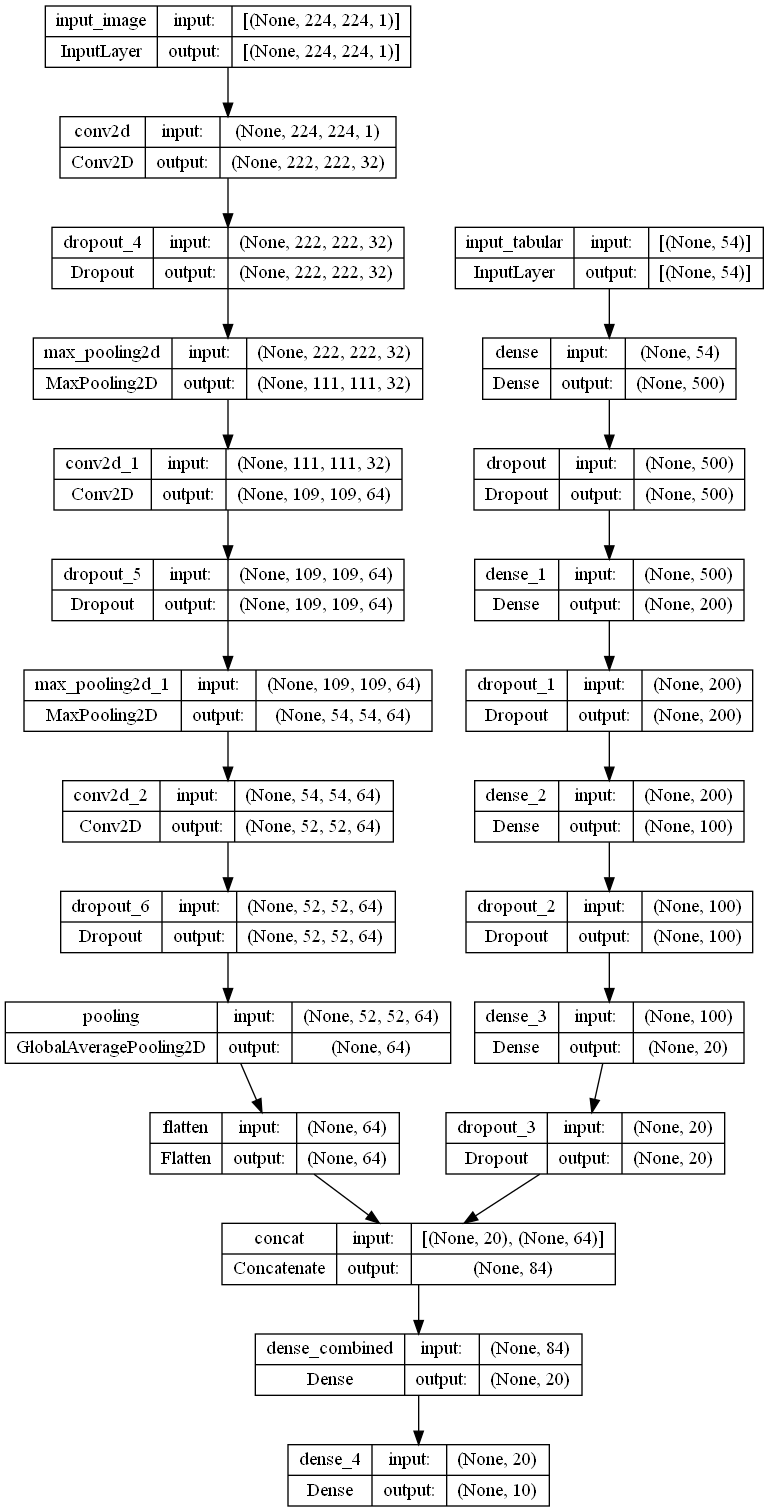

In [37]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

In [38]:
history = model.fit(train_gen, epochs = 50, validation_data = valid_gen, verbose=0)

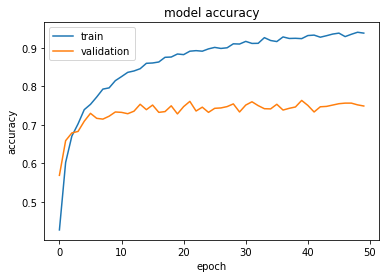

In [43]:
plot_history(history)

In [44]:
y_pred = np.argmax(model.predict(test_gen), axis=1)

124/124 [==============================] - 2s 19ms/step


In [45]:
sum(y_pred == y_test_df)/len(y_pred)

0.7464646464646465

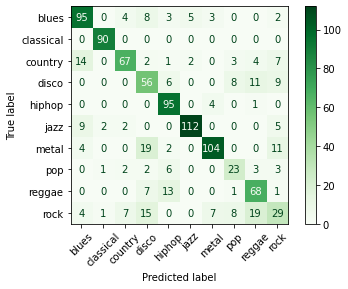

In [46]:
cm = confusion_matrix(y_test_df, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_).plot(xticks_rotation=45, cmap="Greens")

It looks like adding image data to the model didn't significantly help. 

## Concluding remarks

* Data leakage was misrepresenting the accuracy of the classification models that I found online 

* I was able to achieve 91% accuracy with fairly basic refinement when splitting the data the incorrect way (I removed this from the notebook to avoid confusion)

* Approximately 75% accuracy is a more realistic benchmark, based on the models I built using a better splitting method

* The XGBoost model had the best performance

* With further hyperparameter tuning, I expect the accuracy could get closer to 80%

* Due to GPU limitations, I used a fairly simple CNN as part of my mixed-data neural network

* Using a more advanced architecture e.g. ResNet (especially pretrained) and/or larger spectogram images it may be possible to get more accurate predictions than the XGBoost model

* 10,000 3-second clips isn't a huge amount, so training with a larger dataset would be beneficial